In [237]:
from riotwatcher import LolWatcher, ApiError
import pandas as pd
import numpy as np
import requests
import torch
import torch.nn as nn
import torch.optim as optim
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.firefox.options import Options
import time
import re
from scipy.stats import linregress
from datetime import datetime
import statsmodels.formula.api as smf
from pymongo import MongoClient
import altair as alt
client = MongoClient('localhost', 27017)
db = client['OTP_Data']
#db.create_collection('players')

key = 'RGAPI-d2a6e594-5c2c-43c3-a163-e13af6a8a397'
watcher = LolWatcher(key)

In [201]:
region = 'kr'

# 2 api calls
def get_games_by_tag(region, tag):
    player = watcher.summoner.by_name(region, tag)
    matches = watcher.match.matchlist_by_puuid(region, player['puuid'])
    return matches

# 1 api call
def get_matchinfo(region, game_id):
    data = watcher.match.by_id(region, game_id)
    obj = {}
    obj['_id'] = game_id
    obj['game_id'] = data['metadata']['matchId']
    obj['participants'] = data['metadata']['participants']
    obj['match_length'] = data['info']['gameDuration']
    obj['patch'] = data['info']['gameVersion']
    obj['queueId'] = data['info']['queueId']
    obj['region'] = region
    obj['champs'] = data['info']['participants']
    obj['blue_objectives'] = data['info']['teams'][0]['objectives']
    obj['blue_bans'] = data['info']['teams'][0]['bans']
    obj['blue_won'] = data['info']['teams'][0]['win']
    obj['red_objectives'] = data['info']['teams'][1]['objectives']
    obj['red_bans'] = data['info']['teams'][1]['bans']
    obj['red_won'] = data['info']['teams'][1]['win']
    return obj

# 2 api calls, gets champ ids as static data
l = watcher.data_dragon.versions_for_region('na1')['n']['champion']
d = watcher.data_dragon.champions(l, False, 'en_US')['data']
champindeces = [(key, value['key']) for key, value in d.items()]

def player_mastery(region, tag):
    player = watcher.summoner.by_name(region, tag)
    mastery = watcher.champion_mastery.by_summoner(region, player['id'])
    obj = {}
    for i in range(len(mastery)):
        for c in champindeces:
            if mastery[i]['championId'] == int(c[1]):
                obj['_id'] = player['id']
                obj['tag'] = tag
                obj['puuid'] = mastery[i]['puuid']
                obj['summonerId'] = mastery[i]['summonerId']
                obj['region'] = region
                obj[c[0]] = {}
                obj[c[0]]['mastery'] = mastery[i]['championPoints']
                time = mastery[i]['lastPlayTime'] / 1000
                obj[c[0]]['last_played'] = datetime.fromtimestamp(time).strftime("%Y-%m-%d")
    return obj

def is_onetrick(summoner_id, champ_name):
    played_champs = db['players'].find_one({'summonerId': summoner_id})
    if played_champs != None:
        played_champs = list(played_champs.keys())[5:]

        if champ_name == played_champs[0]:
            return 'main'
        elif champ_name in played_champs[1:5]:
            return 'in champ pool'
        else:
            return 'not proficient'
    else:
        return 'no data'


# leaderboard list
linklist = ['https://lolalytics.com/lol/aatrox/leaderboard/',
            
 'https://lolalytics.com/lol/ahri/leaderboard/',
 'https://lolalytics.com/lol/akali/leaderboard/',
 'https://lolalytics.com/lol/akshan/leaderboard/',
 'https://lolalytics.com/lol/alistar/leaderboard/',
 'https://lolalytics.com/lol/amumu/leaderboard/',
 'https://lolalytics.com/lol/anivia/leaderboard/',
 'https://lolalytics.com/lol/annie/leaderboard/',
 'https://lolalytics.com/lol/aphelios/leaderboard/',
 'https://lolalytics.com/lol/ashe/leaderboard/',
 'https://lolalytics.com/lol/aurelionsol/leaderboard/',
 'https://lolalytics.com/lol/azir/leaderboard/',
 'https://lolalytics.com/lol/bard/leaderboard/',
 'https://lolalytics.com/lol/belveth/leaderboard/',
 'https://lolalytics.com/lol/blitzcrank/leaderboard/',
 'https://lolalytics.com/lol/brand/leaderboard/',
 'https://lolalytics.com/lol/braum/leaderboard/',
 'https://lolalytics.com/lol/caitlyn/leaderboard/',
 'https://lolalytics.com/lol/camille/leaderboard/',
 'https://lolalytics.com/lol/cassiopeia/leaderboard/',
 'https://lolalytics.com/lol/chogath/leaderboard/',
 'https://lolalytics.com/lol/corki/leaderboard/',
 'https://lolalytics.com/lol/darius/leaderboard/',
 'https://lolalytics.com/lol/diana/leaderboard/',
 'https://lolalytics.com/lol/draven/leaderboard/',
 'https://lolalytics.com/lol/drmundo/leaderboard/',
 'https://lolalytics.com/lol/ekko/leaderboard/',
 'https://lolalytics.com/lol/elise/leaderboard/',
 'https://lolalytics.com/lol/evelynn/leaderboard/',
 'https://lolalytics.com/lol/ezreal/leaderboard/',
 'https://lolalytics.com/lol/fiddlesticks/leaderboard/',
 'https://lolalytics.com/lol/fiora/leaderboard/',
 'https://lolalytics.com/lol/fizz/leaderboard/',
 'https://lolalytics.com/lol/galio/leaderboard/',
 'https://lolalytics.com/lol/gangplank/leaderboard/',
 'https://lolalytics.com/lol/garen/leaderboard/',
 'https://lolalytics.com/lol/gnar/leaderboard/',
 'https://lolalytics.com/lol/gragas/leaderboard/',
 'https://lolalytics.com/lol/graves/leaderboard/',
 'https://lolalytics.com/lol/gwen/leaderboard/',
 'https://lolalytics.com/lol/hecarim/leaderboard/',
 'https://lolalytics.com/lol/heimerdinger/leaderboard/',
 'https://lolalytics.com/lol/illaoi/leaderboard/',
 'https://lolalytics.com/lol/irelia/leaderboard/',
 'https://lolalytics.com/lol/ivern/leaderboard/',
 'https://lolalytics.com/lol/janna/leaderboard/',
 'https://lolalytics.com/lol/jarvaniv/leaderboard/',
 'https://lolalytics.com/lol/jax/leaderboard/',
 'https://lolalytics.com/lol/jayce/leaderboard/',
 'https://lolalytics.com/lol/jhin/leaderboard/',
 'https://lolalytics.com/lol/jinx/leaderboard/',
 'https://lolalytics.com/lol/kaisa/leaderboard/',
 'https://lolalytics.com/lol/kalista/leaderboard/',
 'https://lolalytics.com/lol/karma/leaderboard/',
 'https://lolalytics.com/lol/karthus/leaderboard/',
 'https://lolalytics.com/lol/kassadin/leaderboard/',
 'https://lolalytics.com/lol/katarina/leaderboard/',
 'https://lolalytics.com/lol/kayle/leaderboard/',
 'https://lolalytics.com/lol/kayn/leaderboard/',
 'https://lolalytics.com/lol/kennen/leaderboard/',
 'https://lolalytics.com/lol/khazix/leaderboard/',
 'https://lolalytics.com/lol/kindred/leaderboard/',
 'https://lolalytics.com/lol/kled/leaderboard/',
 'https://lolalytics.com/lol/kogmaw/leaderboard/',
 'https://lolalytics.com/lol/ksante/leaderboard/',
 'https://lolalytics.com/lol/leblanc/leaderboard/',
 'https://lolalytics.com/lol/leesin/leaderboard/',
 'https://lolalytics.com/lol/leona/leaderboard/',
 'https://lolalytics.com/lol/lillia/leaderboard/',
 'https://lolalytics.com/lol/lissandra/leaderboard/',
 'https://lolalytics.com/lol/lucian/leaderboard/',
 'https://lolalytics.com/lol/lulu/leaderboard/',
 'https://lolalytics.com/lol/lux/leaderboard/',
 'https://lolalytics.com/lol/malphite/leaderboard/',
 'https://lolalytics.com/lol/malzahar/leaderboard/',
 'https://lolalytics.com/lol/maokai/leaderboard/',
 'https://lolalytics.com/lol/masteryi/leaderboard/',
 'https://lolalytics.com/lol/milio/leaderboard/',
 'https://lolalytics.com/lol/missfortune/leaderboard/',
 'https://lolalytics.com/lol/wukong/leaderboard/',
 'https://lolalytics.com/lol/mordekaiser/leaderboard/',
 'https://lolalytics.com/lol/morgana/leaderboard/',
 'https://lolalytics.com/lol/naafiri/leaderboard/',
 'https://lolalytics.com/lol/nami/leaderboard/',
 'https://lolalytics.com/lol/nasus/leaderboard/',
 'https://lolalytics.com/lol/nautilus/leaderboard/',
 'https://lolalytics.com/lol/neeko/leaderboard/',
 'https://lolalytics.com/lol/nidalee/leaderboard/',
 'https://lolalytics.com/lol/nilah/leaderboard/',
 'https://lolalytics.com/lol/nocturne/leaderboard/',
 'https://lolalytics.com/lol/nunu/leaderboard/',
 'https://lolalytics.com/lol/olaf/leaderboard/',
 'https://lolalytics.com/lol/orianna/leaderboard/',
 'https://lolalytics.com/lol/ornn/leaderboard/',
 'https://lolalytics.com/lol/pantheon/leaderboard/',
 'https://lolalytics.com/lol/poppy/leaderboard/',
 'https://lolalytics.com/lol/pyke/leaderboard/',
 'https://lolalytics.com/lol/qiyana/leaderboard/',
 'https://lolalytics.com/lol/quinn/leaderboard/',
 'https://lolalytics.com/lol/rakan/leaderboard/',
 'https://lolalytics.com/lol/rammus/leaderboard/',
 'https://lolalytics.com/lol/reksai/leaderboard/',
 'https://lolalytics.com/lol/rell/leaderboard/',
 'https://lolalytics.com/lol/renata/leaderboard/',
 'https://lolalytics.com/lol/renekton/leaderboard/',
 'https://lolalytics.com/lol/rengar/leaderboard/',
 'https://lolalytics.com/lol/riven/leaderboard/',
 'https://lolalytics.com/lol/rumble/leaderboard/',
 'https://lolalytics.com/lol/ryze/leaderboard/',
 'https://lolalytics.com/lol/samira/leaderboard/',
 'https://lolalytics.com/lol/sejuani/leaderboard/',
 'https://lolalytics.com/lol/senna/leaderboard/',
 'https://lolalytics.com/lol/seraphine/leaderboard/',
 'https://lolalytics.com/lol/sett/leaderboard/',
 'https://lolalytics.com/lol/shaco/leaderboard/',
 'https://lolalytics.com/lol/shen/leaderboard/',
 'https://lolalytics.com/lol/shyvana/leaderboard/',
 'https://lolalytics.com/lol/singed/leaderboard/',
 'https://lolalytics.com/lol/sion/leaderboard/',
 'https://lolalytics.com/lol/sivir/leaderboard/',
 'https://lolalytics.com/lol/skarner/leaderboard/',
 'https://lolalytics.com/lol/sona/leaderboard/',
 'https://lolalytics.com/lol/soraka/leaderboard/',
 'https://lolalytics.com/lol/swain/leaderboard/',
 'https://lolalytics.com/lol/sylas/leaderboard/',
 'https://lolalytics.com/lol/syndra/leaderboard/',
 'https://lolalytics.com/lol/tahmkench/leaderboard/',
 'https://lolalytics.com/lol/taliyah/leaderboard/',
 'https://lolalytics.com/lol/talon/leaderboard/',
 'https://lolalytics.com/lol/taric/leaderboard/',
 'https://lolalytics.com/lol/teemo/leaderboard/',
 'https://lolalytics.com/lol/thresh/leaderboard/',
 'https://lolalytics.com/lol/tristana/leaderboard/',
 'https://lolalytics.com/lol/trundle/leaderboard/',
 'https://lolalytics.com/lol/tryndamere/leaderboard/',
 'https://lolalytics.com/lol/twistedfate/leaderboard/',
 'https://lolalytics.com/lol/twitch/leaderboard/',
 'https://lolalytics.com/lol/udyr/leaderboard/',
 'https://lolalytics.com/lol/urgot/leaderboard/',
 'https://lolalytics.com/lol/varus/leaderboard/',
 'https://lolalytics.com/lol/vayne/leaderboard/',
 'https://lolalytics.com/lol/veigar/leaderboard/',
 'https://lolalytics.com/lol/velkoz/leaderboard/',
 'https://lolalytics.com/lol/vex/leaderboard/',
 'https://lolalytics.com/lol/vi/leaderboard/',
 'https://lolalytics.com/lol/viego/leaderboard/',
 'https://lolalytics.com/lol/viktor/leaderboard/',
 'https://lolalytics.com/lol/vladimir/leaderboard/',
 'https://lolalytics.com/lol/volibear/leaderboard/',
 'https://lolalytics.com/lol/warwick/leaderboard/',
 'https://lolalytics.com/lol/xayah/leaderboard/',
 'https://lolalytics.com/lol/xerath/leaderboard/',
 'https://lolalytics.com/lol/xinzhao/leaderboard/',
 'https://lolalytics.com/lol/yasuo/leaderboard/',
 'https://lolalytics.com/lol/yone/leaderboard/',
 'https://lolalytics.com/lol/yorick/leaderboard/',
 'https://lolalytics.com/lol/yuumi/leaderboard/',
 'https://lolalytics.com/lol/zac/leaderboard/',
 'https://lolalytics.com/lol/zed/leaderboard/',
 'https://lolalytics.com/lol/zeri/leaderboard/',
 'https://lolalytics.com/lol/ziggs/leaderboard/',
 'https://lolalytics.com/lol/zilean/leaderboard/',
 'https://lolalytics.com/lol/zoe/leaderboard/',
 'https://lolalytics.com/lol/zyra/leaderboard/']

In [109]:
options = Options()
options.binary_location = r'C:\Program Files\Mozilla Firefox\firefox.exe'
driver = webdriver.Firefox(executable_path=r'C:\Users\Luke\Documents\RandomSideProjects\LEEG\geckodriver.exe', options=options)
for i in range(110,len(champindeces)): #Sejuani
    if champindeces[i][0] != 'Naafiri':
        driver.get(linklist[i] + '?region=' + region)
        leaderboard = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.CLASS_NAME, 'Leaderboard_leaderboard__v5Apf')))
        time.sleep(2)
        leaderboard = leaderboard.find_elements(By.TAG_NAME, 'a')
        for f in range(len(leaderboard)):
            try:
                leaderboard[f] = leaderboard[f].text
                player_data = player_mastery(region, leaderboard[f])
                if player_data != {}:
                    db['players'].replace_one({'_id': player_data['_id']}, player_data, upsert=True)
                games = get_games_by_tag(region, leaderboard[f])
                for j in range(len(games)):
                    game_info = get_matchinfo(region, games[j])
                    if int(game_info['queueId']) == 420:
                        db[champindeces[i][0]].replace_one({'_id': games[j]}, game_info, upsert=True)
                time.sleep(22)
            except requests.exceptions.RequestException:
                continue

C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\1410879833.py:3: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Firefox(executable_path=r'C:\Users\Luke\Documents\RandomSideProjects\LEEG\geckodriver.exe', options=options)


WebDriverException: Message: Failed to decode response from marionette


In [40]:
import requests
try:
    #leaderboard[f] = leaderboard[f].text
    games = get_games_by_tag(region, leaderboard[f])
    for j in range(len(games)):
        game_info = get_matchinfo(region, games[j])
        if int(game_info['queueId']) == 420 and game_info == {}:
            db[champindeces[i][0]].replace_one({'game_id': games[j]}, game_info, upsert=True)
    player_data = player_mastery(region, leaderboard[f])
    db['players'].replace_one({'summonerId': player_data['summonerId']}, player_data, upsert=True)
    time.sleep(60)
except requests.exceptions.RequestException:
    print('we ball')

we ball


In [212]:
final_df = pd.DataFrame()
for col in db.list_collection_names()[:db.list_collection_names().index('players')] + db.list_collection_names()[db.list_collection_names().index('players') + 1:]:
    for game in db[col].find():
        x = pd.DataFrame(game['champs'])
        y = pd.DataFrame(x['challenges'].tolist())
        df = pd.concat([x, y], axis=1)
        df.drop('challenges', axis=1, inplace=True)
        blue_df = pd.DataFrame()
        names = ['baron','champion','dragon','inhibitor','riftHerald','tower']
        blue = game['blue_objectives']
        for i in range(len(blue)):
            frame = pd.DataFrame(blue[names[i]], index=[0]).rename(columns={'first': 'team_' + names[i] + '_first', 'kills': 'team_' + names[i] + '_kills'})
            blue_df = pd.concat([blue_df, frame], axis=1)
        blue_df = pd.concat([blue_df] * 5, ignore_index=True)
        red_df = pd.DataFrame()
        red = game['red_objectives']
        for i in range(len(red)):
            frame = pd.DataFrame(red[names[i]], index=[0]).rename(columns={'first': 'team_' + names[i] + '_first', 'kills': 'team_' + names[i] + '_kills'})
            red_df = pd.concat([red_df, frame], axis=1)
        red_df = pd.concat([red_df] * 5, ignore_index=True)
        obj = pd.concat([blue_df, red_df], ignore_index=True)
        df = pd.concat([df, obj], axis=1)
        l = []
        for i in range(len(df)):
            l.append(is_onetrick(df.iloc[i]['summonerId'], df.iloc[i]['championName']))
        df['proficiency'] = l
        df['region'] = [game['region']] * 10
        df['gameId'] = [game['game_id']] * 10
        blue_bans = game['blue_bans']
        blue_bans = [obj['championId'] for obj in blue_bans]
        red_bans = game['blue_bans']
        red_bans = [obj['championId'] for obj in red_bans]
        bans = [blue_bans] * 5 + [red_bans] * 5
        df['bans'] = bans
        df = df.loc[:,~df.columns.duplicated()].copy()
        if len(final_df != 0):
            final_df = pd.concat([final_df, df])
        else:
            final_df = df
final_df

KeyboardInterrupt: 

In [236]:
alt.data_transformers.disable_max_rows()
scatter_plot = alt.Chart(df_no_dupes[df_no_dupes['championName'] == 'Kayle']).mark_point().encode(
    x='timePlayed:Q',     # Quantitative variable (time) on x-axis
    y='killParticipation:Q',    # Quantitative variable (value) on y-axis
    color=alt.Color('win:N', scale=alt.Scale(domain=['true', 'false'], range=['blue', 'red']))
).properties(
    width=1000,
    height=600
)

scatter_plot.show()

Displaying chart at http://localhost:53501/


In [240]:
m = smf.ols("timePlayed ~ assists", data=df_no_dupes[df_no_dupes['championName'] == 'Alistar']).fit()  # v ~ R means v = Bo + Bi * R
m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             timePlayed   R-squared:                       0.355
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     2999.
Date:                Fri, 28 Jul 2023   Prob (F-statistic):               0.00
Time:                        20:54:08   Log-Likelihood:                -39048.
No. Observations:                5458   AIC:                         7.810e+04
Df Residuals:                    5456   BIC:                         7.811e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1064.2732      8.234    129.258      0.000    1048.132    1080.415
assists       32.2663      0.589     54.765      0.000      31.111      33.421
==============================================================================
Omnibus:                        8.033   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.018   Jarque-Bera (JB):                8.690
Skew:                           0.051   Prob(JB):                       0.0130
Kurtosis:                       3.166   Cond. No.                         27.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [247]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# corr = df_no_dupes[df_no_dupes['championName'] == 'Alistar'].corr('kendall')
# plt.figure(figsize=(10, 8))
# sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
# plt.title("Correlation Matrix")
# plt.show()
#correlation_with_target = df_no_dupes[df_no_dupes['championName'] == 'Alistar'].corr()['timePlayed'].sort_values(ascending=False)
correlation_with_target

timePlayed                      1.000000
gameLength                      0.999999
thirdInhibitorDestroyedTime     0.962982
champLevel                      0.916500
champExperience                 0.913230
                                  ...   
fastestLegendary                     NaN
fasterSupportQuestCompletion         NaN
soloTurretsLategame                  NaN
hadAfkTeammate                       NaN
threeWardsOneSweeperCount            NaN
Name: timePlayed, Length: 258, dtype: float64

In [249]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)  # Choose the number of components you want to retain
principal_components = pca.fit_transform(alistar)
principal_df = pd.DataFrame(data=principal_components, columns=[f"PC{i+1}" for i in range(pca.n_components_)])
correlation_with_target = principal_df.corrwith(alistar['timePlayed']).sort_values(ascending=False)
print(correlation_with_target)

ValueError: could not convert string to float: 'Alistar'

In [260]:
threshold = 0.3
correlation_matrix = alistar.corr()['win']
high_correlations = correlation_matrix[abs(correlation_matrix) > threshold]
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
high_correlations

C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\801196234.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = alistar.corr()['win']


0.49138132582219723

In [276]:
alistar = df_no_dupes[df_no_dupes['championName'] == 'Alistar']
def find_correlations(df, champname):
    data = df[df['championName'] == champname]
    if len(data) > 1000:
        cm = data.corr()['win']
        return [champname, cm['goldPerMinute'],cm['kda'],cm['maxKillDeficit'],cm['maxLevelLeadLaneOpponent'],cm['kills'],cm['deaths'],cm['assists'],cm['timePlayed']]
    else:
        return []
    
correlation_df = pd.DataFrame(columns=['name', 'goldPerMinute','kda','maxKillDeficit','maxLevelLeadLaneOpponent','kills','deaths','assists','timePlayed'])
for name in db.list_collection_names():
    data = find_correlations(df_no_dupes, name)
    if data != []:
        correlation_df.loc[len(correlation_df.index)] = data
correlation_df

C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\962298069.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = data.corr()['win']
C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\962298069.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = data.corr()['win']
C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\962298069.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cm = data.corr()['win']
C:\Users\Luke\AppData\Local\Temp\ipykernel_3744\962298069.py:5: FutureWarning: 

,name,goldPerMinute,kda,maxKillDeficit,maxLevelLeadLaneOpponent,kills,deaths,assists,timePlayed
0,Zeri,0.573425,0.555755,0.510502,0.452867,0.397496,-0.474899,0.368406,-0.025348
1,Karthus,0.565072,0.555255,0.481114,0.518008,0.336882,-0.402678,0.392581,-0.045373
2,Leona,0.630393,0.547578,0.463187,0.369552,0.143440,-0.395700,0.456490,-0.021630
3,Sett,0.465138,0.507541,0.473379,0.360310,0.323427,-0.362441,0.345540,0.055252
4,Samira,0.606695,0.563538,0.476470,0.473138,0.470971,-0.407094,0.346256,0.012225
5,Lucian,0.557032,0.556243,0.439306,0.456373,0.376930,-0.413166,0.360782,0.002912
6,Darius,0.532227,0.500724,0.470976,0.365912,0.348942,-0.390901,0.320330,-0.024607
7,Vladimir,0.568405,0.559125,0.481243,0.401113,0.390204,-0.440254,0.348339,-0.004878
8,JarvanIV,0.569027,0.579396,0.464470,0.481290,0.305458,-0.457965,0.470525,0.022646
9,Swain,0.469578,0.518557,0.443003,0.407466,0.289161,-0.410755,0.419068,0.015332


In [282]:
scatter_plot = alt.Chart(correlation_df).mark_circle(size=100).encode(
    x='goldPerMinute:Q',
    y='maxLevelLeadLaneOpponent:Q',
    tooltip=['name:N']
).properties(
    width=800,
    height=600
)

text_labels = scatter_plot.mark_image(
    align='left',
    baseline='middle',
    dx=7  # Adjust the label position relative to the point
).encode(
    text='name:N'
)

# Combine the scatter plot and text labels
final_plot = scatter_plot + text_labels

# Show the plot
final_plot.show()

Displaying chart at http://localhost:53501/


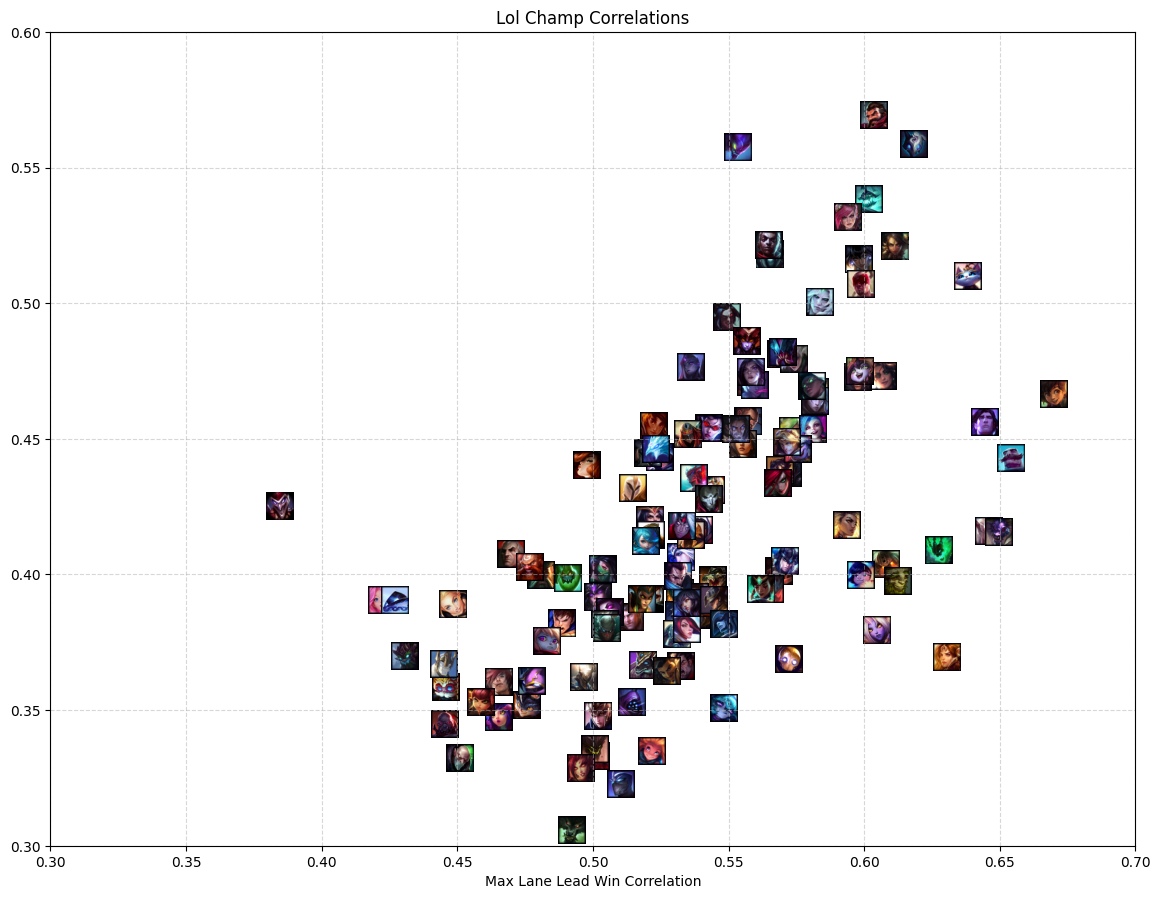

In [314]:
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg
import matplotlib.patches as patches


def plot_icons_on_graph(df):
    fig, ax = plt.subplots(figsize=(14, 12))

    for x, y, icon_path in zip(df['goldPerMinute'], df['maxLevelLeadLaneOpponent'], df['name']):
        if icon_path != 'Naafiri':
            icon = mpimg.imread(rf'C:\Users\Luke\Documents\RandomSideProjects\chatbot\site\lolhelper\src\icons\{icon_path}.png')
            ax.imshow(icon, extent=[x - 0.005, x + 0.005, y - 0.005, y + 0.005], aspect='auto')

    # Set the aspect ratio to equal, so the icons are not distorted.
    ax.set_aspect('equal')

    # Set the axis limits to match the 0 to 1 domain.
    ax.set_xlim(0.3, 0.7)
    ax.set_ylim(0.3, 0.6)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlabel('Gold Per Minute Win Correlation')
    ax.set_xlabel('Max Lane Lead Win Correlation')
    ax.set_title('Lol Champ Correlations')

    plt.show()

plot_icons_on_graph(correlation_df)

In [315]:
db['Aatrox'].find_one()

{'_id': 'KR_6611087629',
 'game_id': 'KR_6611087629',
 'participants': ['2zSIQdJi84jD9ZJpSjZp6rP4vF5TYswPaPqUz4mpbHBdqtbZHRzz3IEQWKVqvEpmE9OjhdTOXjJ0Pg',
  'ZSM4sKP-PO0GmAs-OgqzQNzjq3-EXLxWPmE_1dEdktfx_jO6xMpJQO1ZGtrotFRfcAq9C2E6p1j75Q',
  '-1tBGQWfHSSe1qOo7kLRrfnP5uAERu12v0_JX3BBk3RuptBYHtYdd3GTWDpVwB127kgDX33wkJieSQ',
  'Estq9_XCA3_M9KXMQDIFd4CrztfEWvUmrUvxeL9QngTbGFdgPoEGjL2nd6a_O-WyLMFT3mSCgi9SJw',
  '136NsHd2G5gQvWh2oyyPahO9O19mXjItzvleYTCAtn-wwFolAAdv8UlJwWN22T0mg_i9O1tBP-0ZpQ',
  'Fqng1kuDB5zocEno-u-dG-24KGtlHS3A_78erjV9CIoYiqj0OE6EITmhXnf44ErVGJyQuM5LfcWTcQ',
  'bLRniuVDwNQBOFdeRp-wgb6R_PsUOw_R0dNeN83AdR7xoysecNWL46ap335K0L50fInqow7Jq8C02w',
  'uqX57aPYpc7yqHfzf1n-Ee-7nuzWseh-6gbtMb29i6Buz2N2K_D_7EKS2MlbD31CRcXylcCFcQWscg',
  'PYPim0vSEMU9YNEuq5yPloTs-vcwVT9TT-Kv8aQrqw3DLeoMEm9_Is7c4XxqvuGZyOwSc8H9IVfjWw',
  'trWbgcIcdlJhMjPFOjF3NmW_mbpb4bypIikARQi-XkL37EIlx2oXZsriNCegZtv_ttwu7s3qJwvu-w'],
 'match_length': 1195,
 'patch': '13.14.520.6878',
 'queueId': 420,
 'region': 'kr',
 'ch